In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import utils
import forward_model
import globals
import least_squares
import section_search
import coordinate_descent
import initialization

import torch

/data/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


In [2]:
import tests
tests.test_load_save_dpt()

Test file deleted.


In [4]:
# def test_k_min_indices_no_overlap():
#     width, height, num_Z = 5, 5, 20
#     k = 3
#     gss_window = 2
    
#     # Create random loss values and sort them to get indices
#     np.random.seed(0)
#     all_losses = np.random.rand(width, height, num_Z)
#     sorted_indices = np.argsort(all_losses, axis=2)
#     print(sorted_indices[0,0,:])
    
#     k_min_indices = section_search.k_min_indices_no_overlap(sorted_indices, k=k, gss_window=gss_window)
    
#     assert k_min_indices.shape == (width, height, k)
#     assert np.all(k_min_indices >= 0)
    
#     for i in range(width):
#         for j in range(height):
#             values = np.sort(k_min_indices[i, j])
#             for a in range(len(values)):
#                 for b in range(a+1, len(values)):
#                     assert abs(values[a] - values[b]) >= gss_window, \
#                         f"Overlap violation at ({i},{j}): {values}"
    
    
#     print("Sample indices at (0,0):", k_min_indices[0, 0])
#     print("Corresponding loss values:", all_losses[0, 0][k_min_indices[0, 0]])

# test_k_min_indices_no_overlap()


# def test_k_min_indices_no_overlap_k1():
#     width, height, num_Z = 5, 5, 20
#     k = 1
#     gss_window = 2
    
#     # Create random loss values and sort them to get indices
#     np.random.seed(0)
#     all_losses = np.random.rand(width, height, num_Z)
#     sorted_indices = np.argsort(all_losses, axis=2)
#     print(sorted_indices[0,0,:])
    
#     k_min_indices = section_search.k_min_indices_no_overlap(sorted_indices, k=k, gss_window=gss_window)
    
#     assert k_min_indices.shape == (width, height, k)
#     assert np.all(k_min_indices >= 0)

#     assert np.array_equal(k_min_indices.squeeze(), sorted_indices[:,:,0])

# test_k_min_indices_no_overlap_k1()
    

cpu


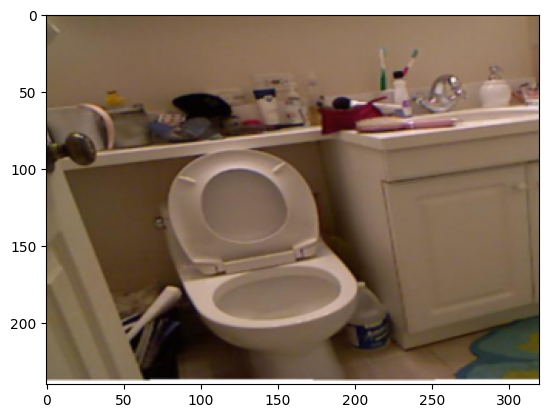

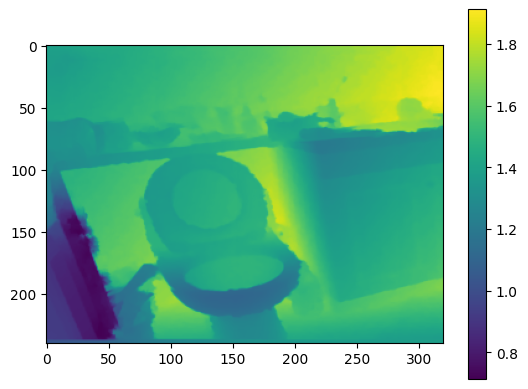

240 320
adaptive kernel size set to 11


In [5]:
globals.init_NYUv2()
globals.thresh = 0.5

# EXPERIMENT_NAME = 'coord-descent-bracket-search'
# experiment_folder = utils.create_experiment_folder(EXPERIMENT_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

IMAGE_RANGE = 255.

# load data 
# gt_aif, gt_dpt = utils.load_single_sample(sample='0101', set='train', fs=5, res='half')
gt_aif, gt_dpt, _ = utils.load_sample_image(fs=5, res='half')
gt_aif = gt_aif * IMAGE_RANGE

plt.imshow(gt_aif / IMAGE_RANGE)
plt.show()

plt.imshow(gt_dpt)
plt.colorbar()
plt.show()

width, height = gt_dpt.shape
print(width, height)

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)

precomputing indices


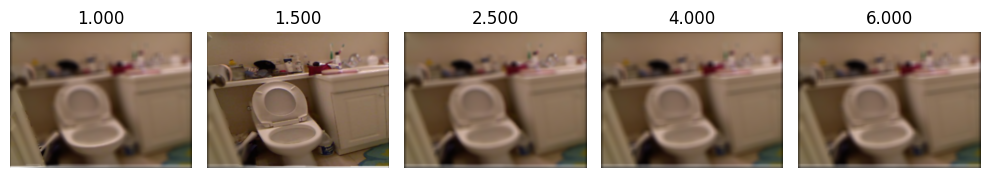

In [6]:
# forward model (torch)
# FORWARD_KERNEL_TYPE = 'gaussian'
defocus_stack = forward_model.forward(gt_dpt, gt_aif)
# defocus_stack_torch = forward_model.forward_torch(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)#.float() / 255.0)
utils.plot_single_stack(defocus_stack / IMAGE_RANGE, globals.Df)



In [7]:
# # test -- can the PGD reconstruct the ground truth AIF from the ground truth depth map?

# recon_aif = least_squares.bounded_fista(gt_dpt, defocus_stack, IMAGE_RANGE, maxiter=2000, gt=gt_aif)


# utils.plot_compare_rgb(gt_aif, recon_aif)
# plt.show()

# print(torch.mean((gt_aif - recon_aif)**2).item())

In [8]:
# dpt = torch.ones((width, height)) * 0.3
# Df_expanded = globals.Df.view(1, 1, -1).to(dpt.device)
# CoC = ((globals.D) 
#         * (torch.abs(dpt.unsqueeze(-1) - Df_expanded) / (dpt.unsqueeze(-1)+1e-8)) 
#         * (globals.f / (Df_expanded - globals.f)))
    
# r = CoC / 2. / globals.ps
# print(r.min())

In [9]:
# recon_aif = least_squares.least_squares(gt_dpt, defocus_stack, maxiter = 500)
# utils.plot_compare_rgb(gt_aif, recon_aif)
# plt.show()

# print(torch.mean((gt_aif - recon_aif)**2).item())

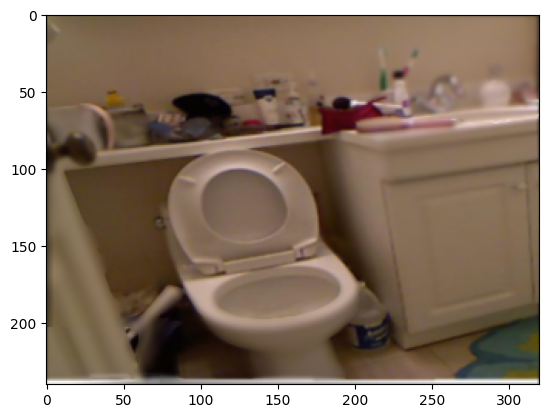

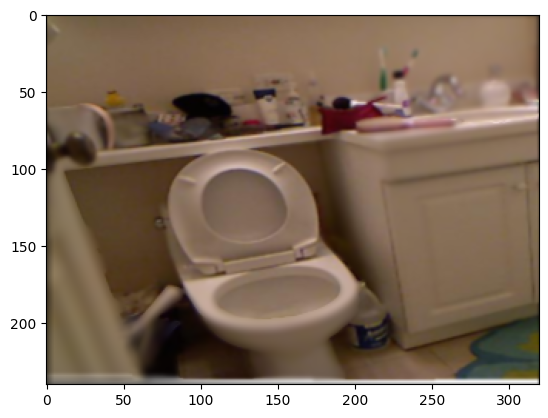

In [10]:
# AIF initialization

# aif_init = initialization.trivial_aif_initialization(defocus_stack)
aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05, sharpness_measure='sobel_grad')
plt.imshow(aif_init / IMAGE_RANGE)
plt.show()

plt.imshow(defocus_stack[1] / IMAGE_RANGE)
plt.show()

precomputing indices
Created experiment folder: experiments/coord-descent_2026-01-06_23-27-14
Images in range [0-255]
precomputing indices


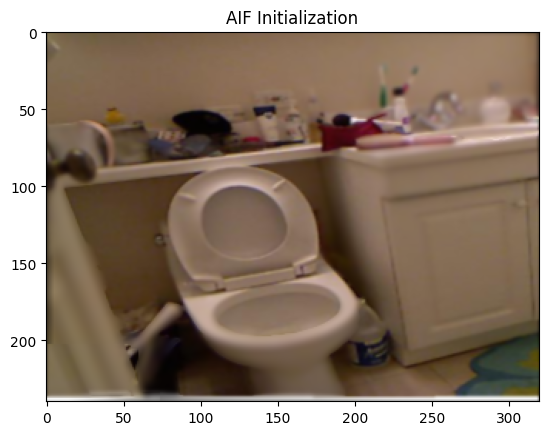

Iteration 0 



Grid search         : 100%|███████████████████| 100/100 [00:17<00:00,  5.62it/s]


GRID SEARCH DURATION 17.985445499420166


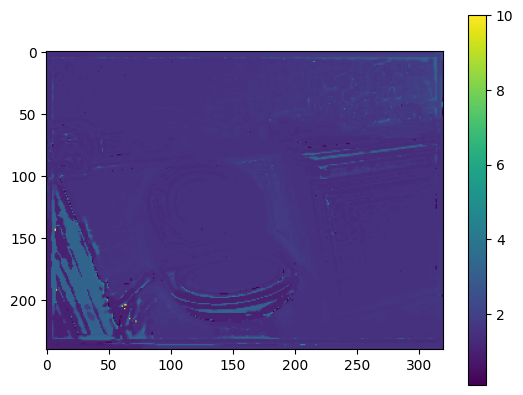


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 17.734710931777954


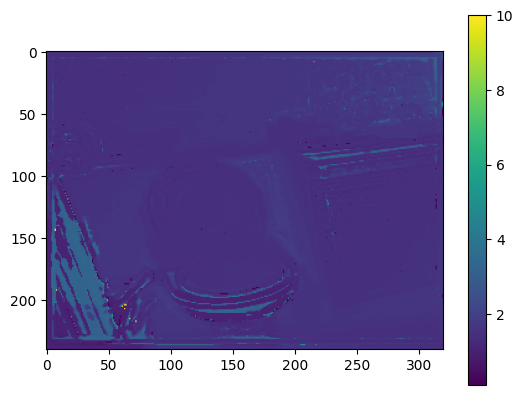

Loss: 8.938162 , TV: 13220.861

DPT result range: [ 0.104508504 , 9.995491 ]


Bounded FISTA...


Optimizing: 100%|█████████████████████████████| 200/200 [01:35<00:00,  2.10it/s]


r1norm 1768.9624 norm(x) 51329.402
FISTA duration 99.2964723110199

AIF result range: [ 0.0 , 255.0 ]
Loss: 2.7164702 , TV: 3360573.0


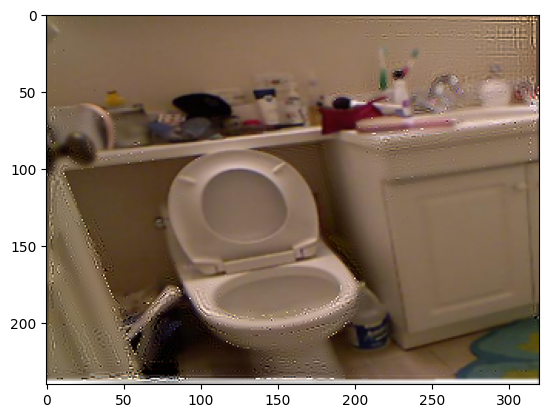

FULL ITER DURATION 137.86533904075623
T_i updated to 210


--------------------------

Iteration 1 



Grid search         : 100%|███████████████████| 100/100 [00:17<00:00,  5.66it/s]


GRID SEARCH DURATION 17.880476236343384


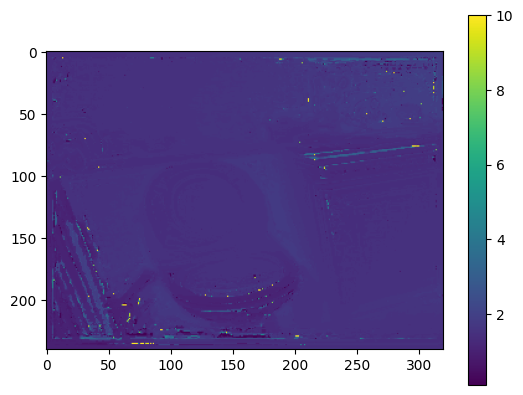


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 19.633185148239136


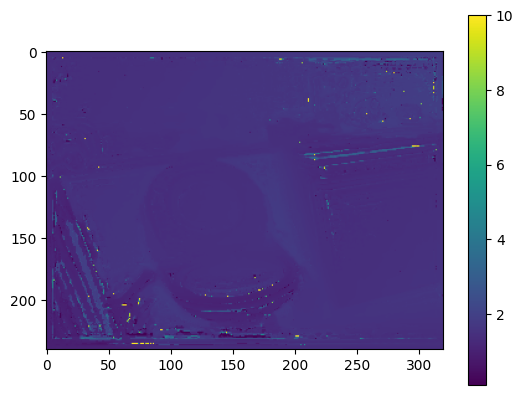

Loss: 1.6471543 , TV: 13201.979

DPT result range: [ 0.104508504 , 9.995491 ]


Bounded FISTA...


Optimizing: 100%|█████████████████████████████| 210/210 [01:39<00:00,  2.12it/s]


r1norm 1019.17706 norm(x) 51495.02
FISTA duration 103.13035273551941

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.90169483 , TV: 3508959.8


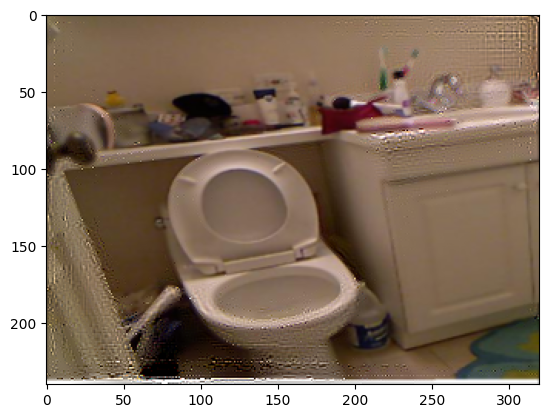

FULL ITER DURATION 143.67631649971008
T_i updated to 220


--------------------------



In [11]:
# -------------------
# COORDINATE DESCENT
# -------------------

# depth_init = 1#torch.median(gt_dpt.cpu()).item()
# print('initializing depth to',depth_init)

# dpt, aif, _, _ = coordinate_descent.coordinate_descent(defocus_stack, show_plots = True,
#         save_plots = False, num_epochs = 2,
#         # least_squares_first=True, depth_init=depth_init,
#         least_squares_first = False, aif_init = aif_init,                                             
#         k = 1, aif_method = 'fista',
#         finite_differences = False, num_Z = 100, 
#         ls_maxiter = 200, ls_maxiter_multiplier = 1.05, 
#         vmin = 0.1, vmax = 10, verbose = True)

# np.save("dpt_template.npy", dpt)
# np.save("aif_template.npy", aif)

aif = np.load('aif_template.npy')
dpt = np.load('dpt_template.npy')

defocus_stack = forward_model.forward(gt_dpt, gt_aif)
aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05, sharpness_measure='sobel_grad')


dpt_v2, aif_v2, _, _ = coordinate_descent.coordinate_descent_v2(defocus_stack, show_plots = True,
        save_plots = False, num_epochs = 2,
        # least_squares_first=True, depth_init=depth_init,
        least_squares_first = False, aif_init = aif_init,                                             
        num_Z = 100, 
        T_0 = 200, alpha = 1.05, 
        vmin = 0.1, vmax = 10, verbose = True)



In [12]:
diff = (dpt- dpt_v2)
# assert np.allclose(dpt-dpt_v2, 0, rtol=1e-3, atol=1e-3)
# assert np.allclose(aif, aif_v2)
np.isnan(diff).any(), np.isinf(diff).any()
np.max(np.abs(dpt - dpt_v2))

diff = np.abs(dpt - dpt_v2)

# where is the worst mismatch?
flat_i = diff.argmax()
idx = np.unravel_index(flat_i, diff.shape)

print("shape dpt:", dpt.shape, "shape dpt_v2:", dpt_v2.shape, "diff shape:", diff.shape)
print("max diff:", diff[idx], "at idx:", idx)
print("dpt[idx]:", dpt[idx], "dpt_v2[idx]:", dpt_v2[idx])

# how widespread is the problem?
print("mean diff:", diff.mean())
print("median diff:", np.median(diff))
print(">1e-3 count:", (diff > 1e-3).sum(), "out of", diff.size)
print(">1e-2 count:", (diff > 1e-2).sum())
print(">1e-1 count:", (diff > 1e-1).sum())

shape dpt: (240, 320) shape dpt_v2: (240, 320) diff shape: (240, 320)
max diff: 0.0 at idx: (0, 0)
dpt[idx]: 1.5922986 dpt_v2[idx]: 1.5922986
mean diff: 0.0
median diff: 0.0
>1e-3 count: 0 out of 76800
>1e-2 count: 0
>1e-1 count: 0


In [13]:
print('RMS', utils.compute_RMS(dpt.numpy(), gt_dpt.numpy()))
print('Rel', utils.compute_Rel(dpt.numpy(), gt_dpt.numpy()))
print(utils.compute_accuracy_metrics(dpt.numpy(), gt_dpt.numpy()))

# todo: fista check if A @ x is quicker stacked or in loop

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [ ]:
plt.imshow(utils.load_NYUv2_dpt('experiments/coord-descent_2025-08-13_14-22-48/iteration0/dpt_0.tiff', resize_frac=0.5))
plt.show()

In [ ]:
dpt_no_outliers = section_search.remove_outliers(dpt.cpu().numpy(), aif, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
plt.imshow(dpt_no_outliers, vmin=0.7, vmax=1.9)
plt.show()

aif_last = least_squares.least_squares(torch.from_numpy(dpt_no_outliers), defocus_stack, maxiter=2500)

criterion = torch.nn.MSELoss()
recon = forward_model.forward_torch(torch.from_numpy(dpt_no_outliers), torch.from_numpy(aif_last))
loss = criterion(recon, defocus_stack_torch)
print(loss.item())

In [ ]:
utils.plot_compare_rgb(aif_last, gt_aif)
plt.show()

In [ ]:
utils.plot_compare_greyscale(dpt_no_outliers, gt_dpt, vmin=0.7, vmax=1.9)
plt.show()

In [ ]:
print(loss.item())


In [ ]:
dpt_no_outliers = section_search.remove_outliers(depth_map_golden, aif_last, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
plt.imshow(dpt_no_outliers, vmin=0.7, vmax=1.9)
plt.show()

In [ ]:
# worst_coords = utils.get_worst_diff_pixels(dpt.cpu(), gt_dpt,
#     num_worst_pixels = 20)

# _, Z, _, all_losses = section_search.grid_search(aif.cpu(), defocus_stack_torch.cpu())

indices = forward_model.precompute_indices(width, height)
defocus_stacks = torch.zeros((len(Z), 5, width, height, 3))
for k in range(len(Z)):
    defocus_stack_k = forward_model.forward_torch(torch.full((width,height), Z[k]).to(aif.device),
                                                  aif, indices=indices)

    defocus_stacks[k] = defocus_stack_k
# 
for i, j in worst_coords[:5]:
    section_search.plot_grid_search_on_pixel(i.item(), j.item(), Z, all_losses, gt_dpt)
    
    i_min = max(0, i.item()-max_kernel_size//2)
    i_max = min(width, i.item()+max_kernel_size//2+1)
    j_min = max(0, j.item()-max_kernel_size//2)
    j_max = min(height, j.item()+max_kernel_size//2+1)
    plt.imshow(aif.cpu()[i_min:i_max, j_min:j_max] / 255.)
    plt.title("Local AIF region for ("+str(i.item())+", "+str(j.item())+")")
    plt.show()
    print('Red range:',aif.cpu()[i_min:i_max, j_min:j_max, 0].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 0].max().item())
    print('Green range:',aif.cpu()[i_min:i_max, j_min:j_max, 1].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 1].max().item())
    print('Blue range:',aif.cpu()[i_min:i_max, j_min:j_max, 2].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 2].max().item())
    print('TV of AIF region:',section_search.total_variation_torch(aif[i_min:i_max, j_min:j_max]).item())
    # plt.imshow(gt_aif.cpu()[i_min:i_max, j_min:j_max] / 255.)
    # plt.title("GT local region for ("+str(i.item())+", "+str(j.item())+")")
    # plt.show()
    
    plt.imshow(dpt.cpu()[i_min:i_max, j_min:j_max], vmin=0.9, vmax=1.7)
    plt.title("Local DPT region for ("+str(i.item())+", "+str(j.item())+")")
    plt.show()
    print('TV of depth map region:',section_search.total_variation_torch(dpt[i_min:i_max, j_min:j_max]).item())

    
    # plt.imshow(defocus_stacks[:,:,i.item(),j.item(),:] / 255.)
    # plt.show()

    
    mse = torch.mean((defocus_stacks[:,:,i.item(),j.item(),:] - defocus_stack_torch[:,i.item(),j.item(),:]) ** 2, axis=2)
    # plt.imshow(mse)
    # plt.colorbar()
    # plt.show()

    fig, ax = plt.subplots(figsize=(10, 20))
    cax = ax.imshow(mse, cmap="viridis", aspect="auto", interpolation="nearest")
    
    cbar = plt.colorbar(cax, ax=ax, shrink=0.3)
    cbar.set_label("Color Scale")
    
    ax.set_yticks(np.arange(len(Z)))
    ax.set_yticklabels([np.round(z,2) for z in Z], fontsize=8)
    ax.set_ylabel('Z (Depth)', fontsize=10)
    
    ax.set_xticks(np.arange(len(globals.Df)))
    ax.set_xticklabels([df.item() for df in globals.Df], fontsize=8)
    ax.set_xlabel('d_f (Focus Setting in Focal Stack)', fontsize=10)
    
    ax.grid(which="minor", color="white", linestyle="-", linewidth=1)
    ax.set_xticks(np.arange(-0.5, 5, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 100, 1), minor=True)
    
    plt.show()



In [ ]:
plt.imshow((dpt.cpu()-gt_dpt.cpu())**2)
plt.colorbar()
plt.title('(DPT - GT DPT)^2')
plt.show()

In [ ]:
tol=0.1
for df in globals.Df:
    mask = np.abs(gt_dpt.detach().cpu().numpy() - df.item()) <= tol
    y_coords, x_coords = np.where(mask)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(gt_dpt.cpu(), vmin=0.9, vmax=1.7)
    plt.scatter(x_coords, y_coords, color='red', marker='x', s=10, label=f'Within ±{tol} of {df}m')
    plt.legend()
    plt.title('Points Close to '+str(df.item())+' m')
    plt.axis('off')
    plt.show()

In [ ]:
pad = max_kernel_size // 2
width, height, _ = aif.shape

gt_aif_tv_map = np.zeros((width, height))
aif_tv_map = np.zeros((width, height))
gt_tv_map = np.zeros((width, height))
tv_map = np.zeros((width, height))

for i in range(pad, width - pad):
    for j in range(pad, height - pad):
        gt_window = gt_aif.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        gt_aif_tv_map[i, j] = coordinate_descent.total_variation_torch(gt_window).item()
        window = aif.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        aif_tv_map[i, j] = coordinate_descent.total_variation_torch(window).item()
        
        gt_window = gt_dpt.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        gt_tv_map[i, j] = coordinate_descent.total_variation_torch(gt_window).item()
        window = dpt.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        tv_map[i, j] = coordinate_descent.total_variation_torch(window).item()

vmin = min(aif_tv_map.min(), gt_aif_tv_map.min())
vmax = max(aif_tv_map.max(), gt_aif_tv_map.max())
utils.plot_compare_greyscale((aif_tv_map - vmin) / (vmax-vmin), (gt_aif_tv_map - vmin) / (vmax-vmin))
# plt.title('TV of AIF')
plt.show()

vmin = min(tv_map.min(), gt_tv_map.min())
vmax = max(tv_map.max(), gt_tv_map.max())
utils.plot_compare_greyscale((tv_map - vmin) / (vmax-vmin), (gt_tv_map - vmin) / (vmax-vmin))
# plt.title('TV of depth maps')
plt.show()

In [ ]:
print(dpt.cpu()[i.item(),j.item()])
print(gt_dpt.cpu()[i.item(),j.item()])

In [ ]:
u, v, row, col, mask = indices

r = forward_model.computer(gt_dpt, globals.Df)
print(r.shape)
_, _, fs = r.shape
r = r.unsqueeze(-1).unsqueeze(-1)
    
G, _ = forward_model.computeG(r, u, v)
print(G.shape)

In [ ]:
print(r[i.item(),j.item()])

In [ ]:
num_plots = len(globals.Df)
fig, axes = plt.subplots(1, num_plots, figsize=(20, 5), constrained_layout=True)

vmin = 0#torch.min(G[222, 178, :, :, :]).item()
vmax = 0.05#torch.max(G[222, 178, :, :, :]).item()

# Plot each subplot with a shared color scale
for k in range(num_plots):
    im = axes[k].imshow(G[i.item(), j.item(), k, :, :].cpu(), vmin=vmin, vmax=vmax)  # Ensure it's on CPU for plotting
    axes[k].set_title(globals.Df[k].item())
    print(G[i.item(), j.item(), k, :, :].sum())

# Create a global colorbar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.02)
cbar.set_label("Color Scale")

# Show the figure
plt.title('Blur Kernels')
plt.show()

In [ ]:
utils.plot_single_stack(defocus_stack_torch[:,i_min:i_max,j_min:j_max,:], globals.Df, recon_max=255.)


In [ ]:
utils.plot_single_stack(forward_model.forward_torch(dpt.cpu(), aif.cpu())[:,i_min:i_max,j_min:j_max,:], globals.Df, recon_max=255.)


In [ ]:
print(u.shape, v.shape, r.shape, G.shape)

In [ ]:
print(defocus_stack_torch[i.item(),j.item()])

In [ ]:
forward_model.forward_torch(dpt.cpu(), aif.cpu())[:,i_min:i_max,j_min:j_max,:]